## Imports

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import os 

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Plotting function

In [2]:
def plot_F1(F1, expcode, expcodes, save_path):
    for model, M_results in F1.items():
        x = []; y = []; z1 = []; z2 = []

    #     fig, axs = plt.subplots(1, 2, figsize = (13,5))
        fig = plt.figure(figsize = (13,6))    
        ax1 = fig.add_subplot(121, projection='3d'); ax2 = fig.add_subplot(122, projection='3d')

        for test_perc, T_results in M_results.items():
            perc = test_perc.split("=")[1]
            for item in T_results:
                x.append(float(perc)); y.append(item['num_epochs']);z1.append(item['avg_f1'][0]); z2.append(item['avg_f1'][1])
        
        fig.suptitle(expcodes[expcode]+ "_" + model, fontsize=16)
        ax1.set_zlim(0, 1); ax2.set_zlim(0, 1)
        ax1.set_xlabel('test_perc'); ax2.set_xlabel('test_perc')
        ax1.set_ylabel('num_epochs'); ax2.set_ylabel('num_epochs')
        ax1.set_zlabel('F1'); ax2.set_zlabel('F1')
        ax1.set_title('Avg Macro'); ax2.set_title('Avg Weighted')
        fig.subplots_adjust(wspace=0.5)
        ax1.scatter3D(np.array(x), np.array(y), np.array(z1), c=np.array(z1), cmap='viridis')
        ax2.scatter3D(np.array(x), np.array(y), np.array(z2), c=np.array(z2), cmap='viridis')
        
        plt.savefig(f"{save_path}/{expcodes[expcode]}_{model}")
        plt.show()
        
def select_best_scores(dictionary):
    results_list = []
    for key, value in dictionary.items():
        for model, T_results in value.items():
            for item in T_results:
#                 print(model," -- ", key," -- ",item['num_epochs']," -- ",item['avg_f1'][0])
                results_list.append([model, key, item['num_epochs'], item['avg_f1'][1]])
    results_list.sort(key=lambda x:x[3], reverse = True)
    print(results_list[0:3])
    
    
        

def transform_data(dictionary):
    new_dict = {}
    for key, value in dictionary.items():
        for model, T_results in value.items():
            if model in new_dict:
                new_dict[model][key] = T_results
            else:
                new_dict[model] = {}
                new_dict[model][key] = T_results
            
    return new_dict
    
  

## Data loading

Temporary requirement: Put all the EXPi folders in a single folder called `F1_multiclass_results` in the `input` folder.

**Note:** Jordi, I know you used `Path` but for some reason I was not able to retrieve all the json files using that method, so I added an alternative.

../input/F1_multiclass_results/EXP10_FineTuningResults.json
../input/F1_multiclass_results/EXP11_FineTuningResults.json
../input/F1_multiclass_results/EXP12_FineTuningResults.json
../input/F1_multiclass_results/EXP13_FineTuningResults.json
../input/F1_multiclass_results/EXP14_FineTuningResults.json
../input/F1_multiclass_results/EXP15_FineTuningResults.json
../input/F1_multiclass_results/EXP16_FineTuningResults.json
../input/F1_multiclass_results/EXP17_FineTuningResults.json
../input/F1_multiclass_results/EXP18_FineTuningResults.json
../input/F1_multiclass_results/EXP19_FineTuningResults.json
../input/F1_multiclass_results/EXP1_FineTuningResults.json
../input/F1_multiclass_results/EXP20_FineTuningResults.json
../input/F1_multiclass_results/EXP21_FineTuningResults.json
../input/F1_multiclass_results/EXP22_FineTuningResults.json
22 ../input/F1_multiclass_results/EXP22_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 10, 0.7814051480918691], ['paraphrase-xlm-

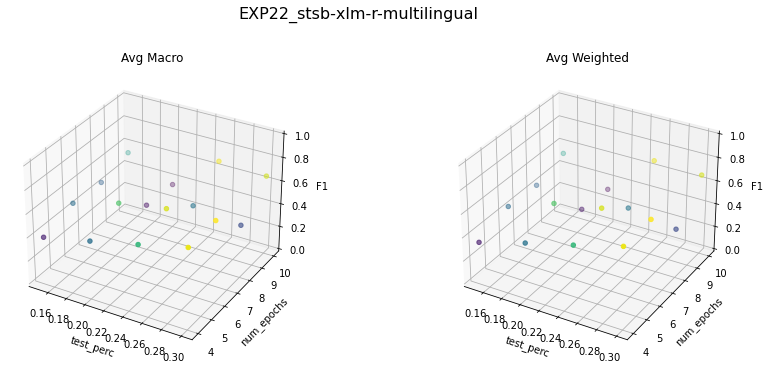

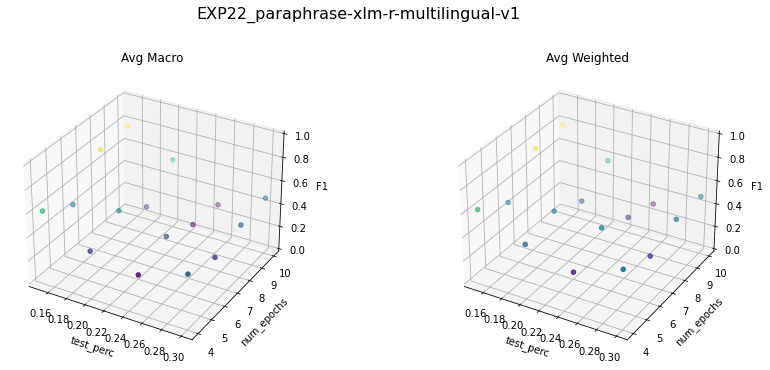

../input/F1_multiclass_results/EXP23_FineTuningResults.json
23 ../input/F1_multiclass_results/EXP23_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 4, 0.8348561972263822], ['stsb-xlm-r-multilingual', 'test_perc=0.25', 8, 0.8330049148514294], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.8218745862936323]]


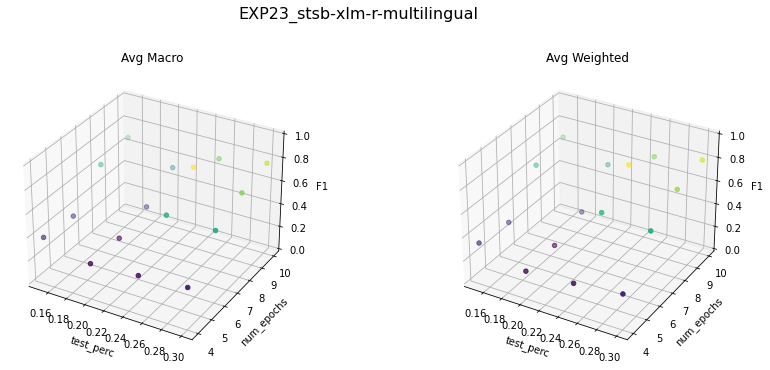

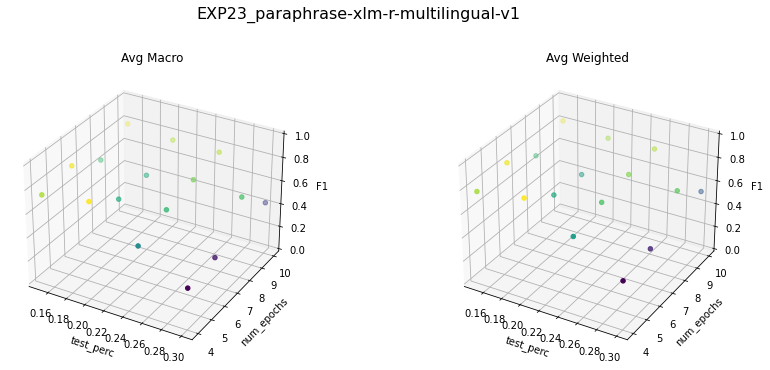

../input/F1_multiclass_results/EXP24_FineTuningResults.json
24 ../input/F1_multiclass_results/EXP24_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 4, 0.6], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 8, 0.5530612244897959], ['stsb-xlm-r-multilingual', 'test_perc=0.15', 6, 0.4841698841698842]]


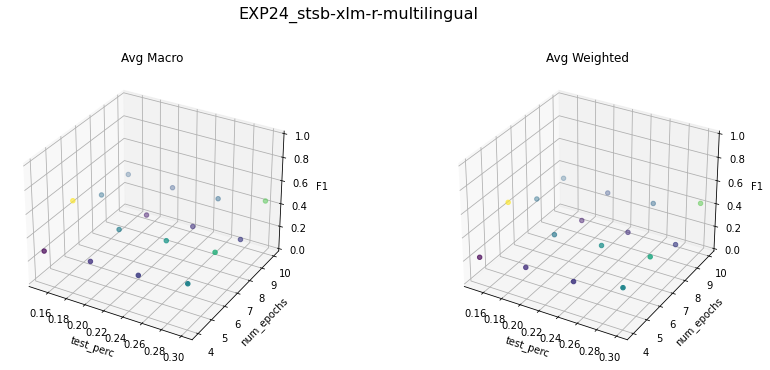

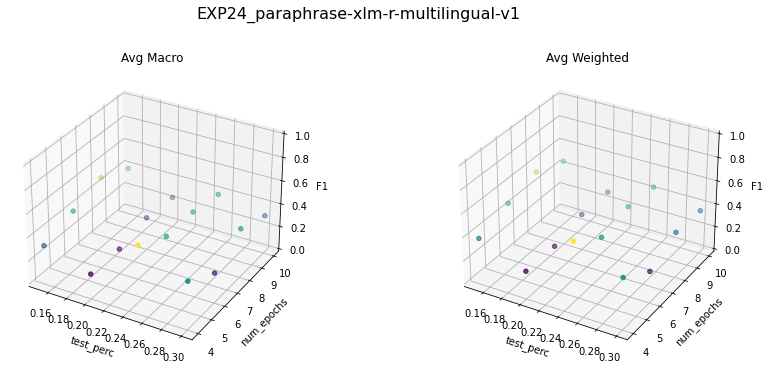

../input/F1_multiclass_results/EXP25_FineTuningResults.json
25 ../input/F1_multiclass_results/EXP25_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 6, 0.7675118439721996], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 6, 0.7671541012508876], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 8, 0.7398105870285454]]


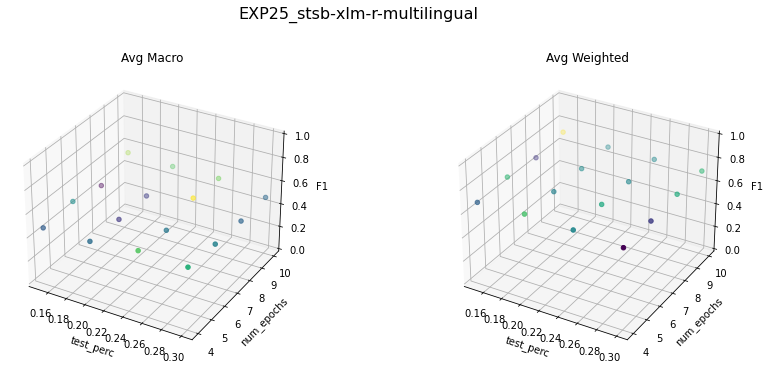

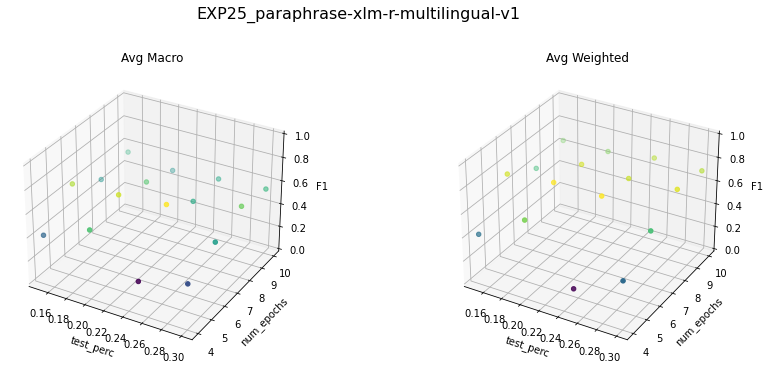

../input/F1_multiclass_results/EXP26_FineTuningResults.json
26 ../input/F1_multiclass_results/EXP26_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 6, 0.8104858576480202], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 8, 0.7423909102999039], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 6, 0.7364347751418046]]


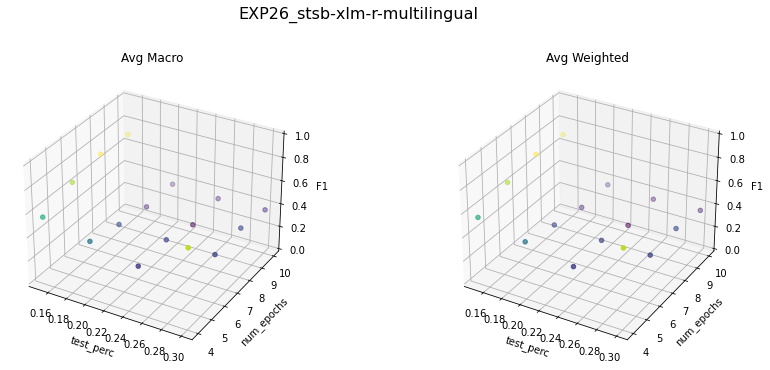

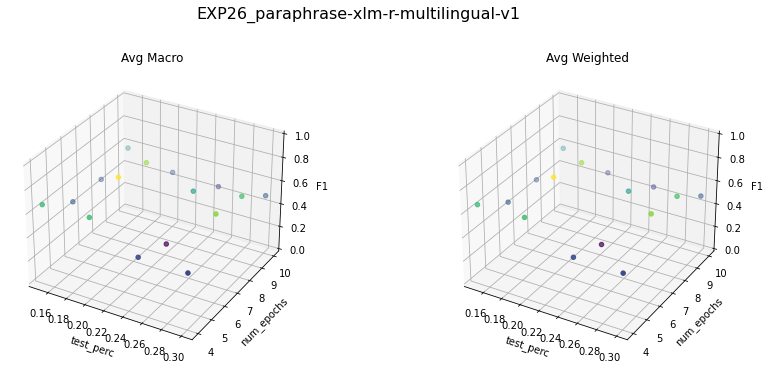

../input/F1_multiclass_results/EXP27_FineTuningResults.json
27 ../input/F1_multiclass_results/EXP27_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 8, 0.670384608291686], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 10, 0.6463403576906512], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.5900246782654363]]


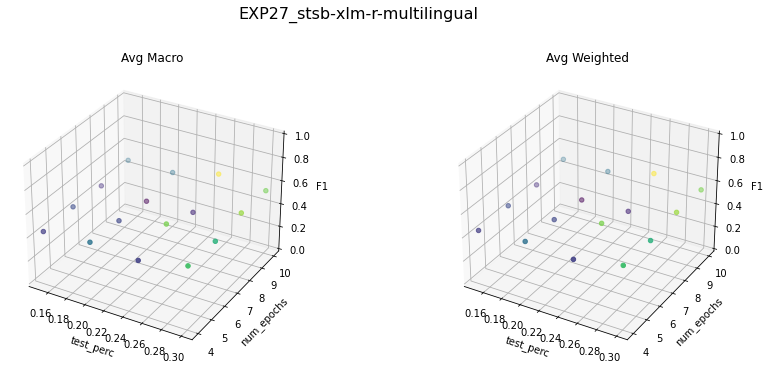

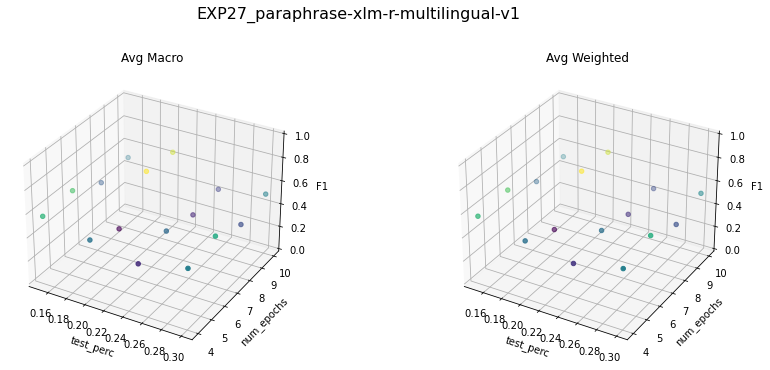

../input/F1_multiclass_results/EXP28_FineTuningResults.json
28 ../input/F1_multiclass_results/EXP28_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 10, 0.6766210320445314], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 4, 0.6700363763148727], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 4, 0.6661394335735191]]


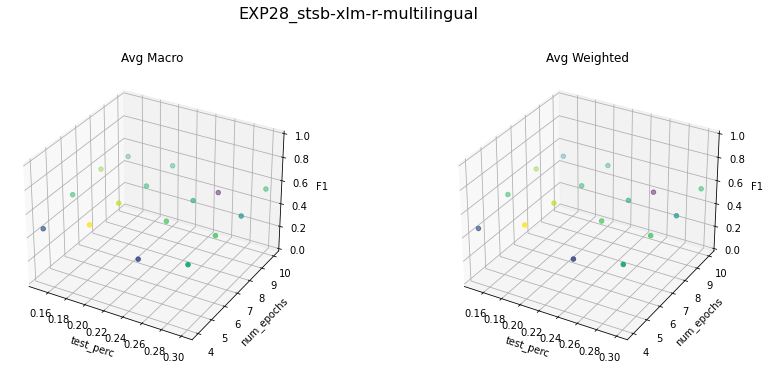

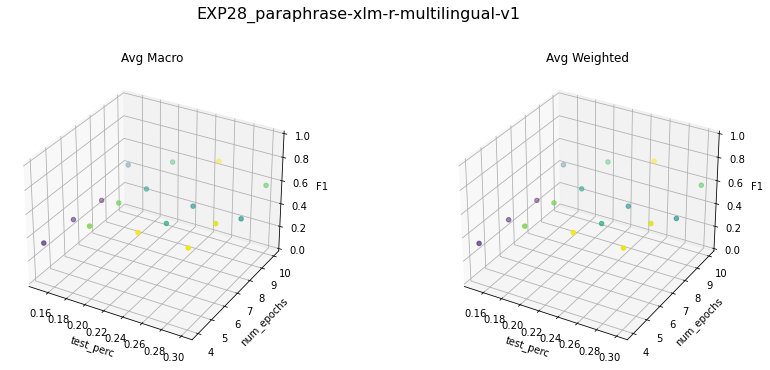

../input/F1_multiclass_results/EXP29_FineTuningResults.json
29 ../input/F1_multiclass_results/EXP29_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.7626572983557462], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.2', 4, 0.6960983512064967], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 4, 0.6896890784050744]]


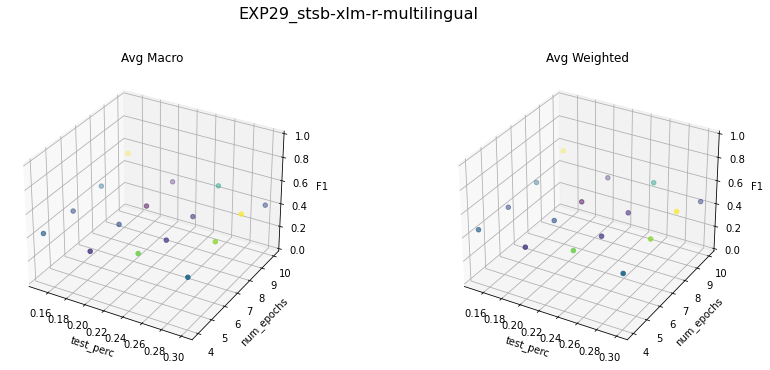

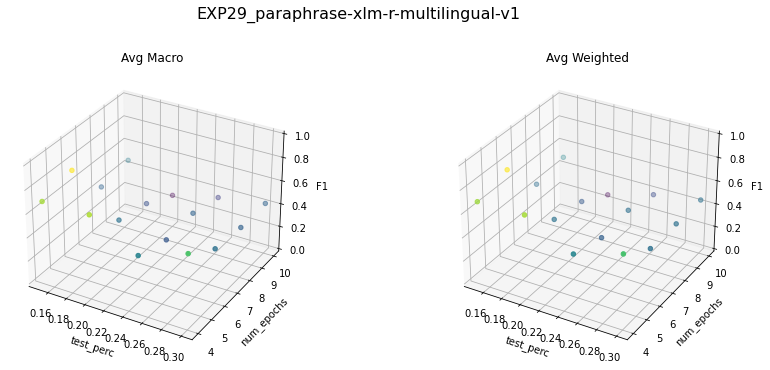

../input/F1_multiclass_results/EXP2_FineTuningResults.json
../input/F1_multiclass_results/EXP30_FineTuningResults.json
30 ../input/F1_multiclass_results/EXP30_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 10, 0.8926478588050409], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 8, 0.8166646864746795], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.15', 6, 0.8163546798029556]]


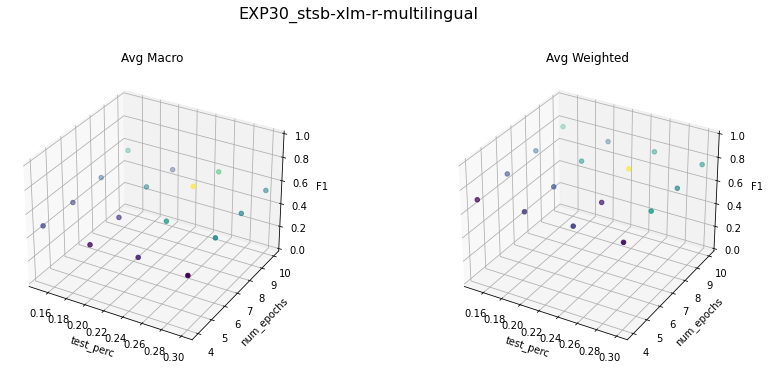

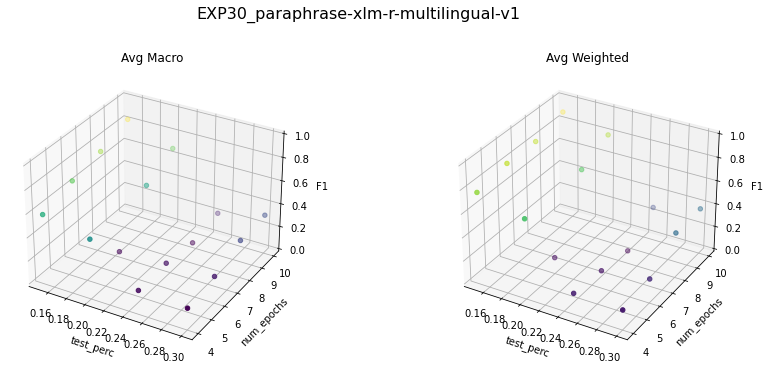

../input/F1_multiclass_results/EXP3_FineTuningResults.json
../input/F1_multiclass_results/EXP4_FineTuningResults.json
../input/F1_multiclass_results/EXP5_FineTuningResults.json
../input/F1_multiclass_results/EXP6_FineTuningResults.json
../input/F1_multiclass_results/EXP7_FineTuningResults.json
../input/F1_multiclass_results/EXP8_FineTuningResults.json
../input/F1_multiclass_results/EXP9_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP10_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP11_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP12_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP13_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP14_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP15_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP20_FineTuningResults.json
../input/F1_multiclass_results/Initial_results\EXP21_Fi

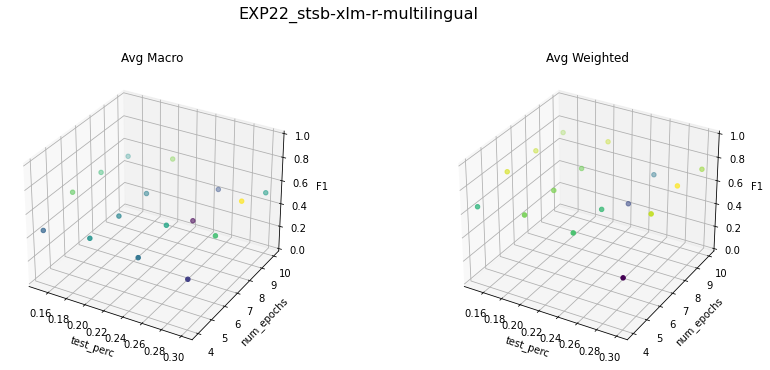

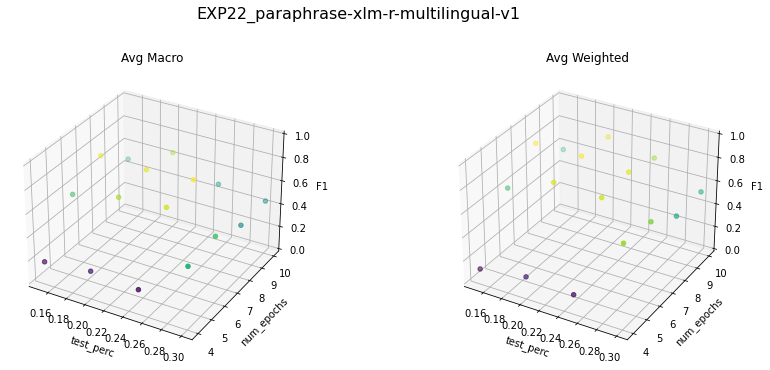

../input/F1_multiclass_results/Initial_results\EXP30_FineTuningResults.json
30 ../input/F1_multiclass_results/Initial_results\EXP30_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 4, 0.5659049308557594], ['stsb-xlm-r-multilingual', 'test_perc=0.15', 6, 0.5169754637118495], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 6, 0.5114697676665038]]


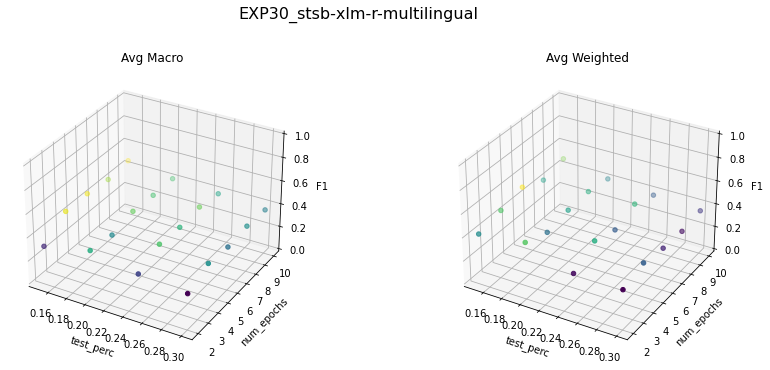

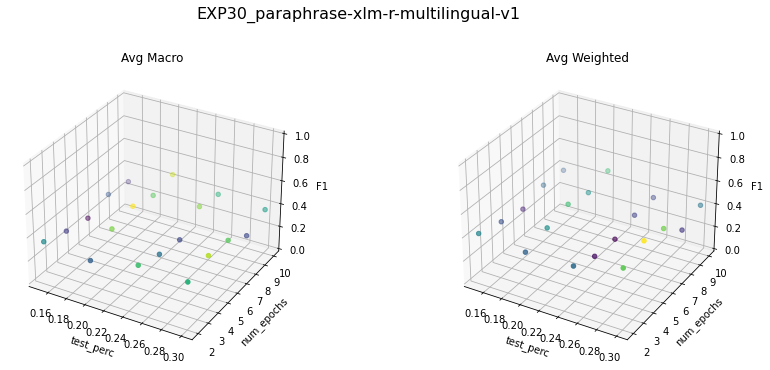

../input/F1_multiclass_results/Initial_results\EXP31_FineTuningResults.json
31 ../input/F1_multiclass_results/Initial_results\EXP31_FineTuningResults.json
[['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.3', 8, 0.5848941297062825], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 6, 0.5780888668926456], ['paraphrase-xlm-r-multilingual-v1', 'test_perc=0.25', 8, 0.5728650331180626]]


KeyError: '31'

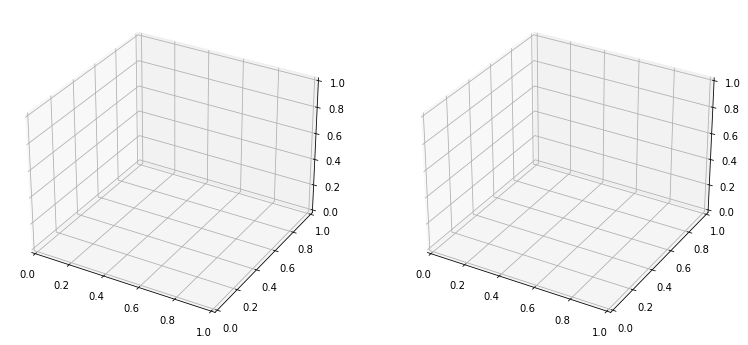

In [6]:
# path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults")
# filename = "FineTuningResults.json"

# sub_path = Path("C:/Users/user/Google Drive/Els_meus_documents/projectes/CompetitiveIntelligence/WRI/Notebooks/Data/finetuningResults/")
# paths = sub_path.glob('*.json')


models = ["stsb-xlm-r", "paraphrase-xlm-r"]#"distiluse-base", "quora-distilbert", 

# exp_codes = {'0' : "Rater2 combined labels",
#             '1' : "Rater2 only new labels",
#             '2' : "Rater3 combined labels",
#             '3' : "Rater3 only new labels",
#             '4' : "Rater1 combined labels",
#             '5' : "Rater1 only new labels"}

bin_exp_codes = {'3' : "Merged raters with LGBM classifier",
            '4' : "Merged raters with SVM classifier"}

# exp_codes = {'20' : "Rater3",
#             '21' : "Rater2",
#             '22' : "Rater1"}
# exp_codes = {'30' : "Rater1 only new test old",
#             '31' : "Rater2 only new test old",
#             '32' : "Rater3 only new test old"}
# exp_codes = {'50' : "Rater1 binary",
#             '51' : "Rater2 binary",
#             '52' : "Rater3 binary"}
exp_codes = {'1' : "EXP1", 
             '2' : "EXP2",
             '3' : "EXP3",
             '4' : "EXP4",
             '5' : "EXP5",
             '6' : "EXP6",
             '7' : "EXP7",
             '8' : "EXP8", 
             '9' : "EXP9",
             '10' : "EXP10",
             '11' : "EXP11",
             '12' : "EXP12",
             '13' : "EXP13",
             '14' : "EXP14", 
             '15' : "EXP15",
             '16' : "EXP16",
             '17' : "EXP17", 
             '18' : "EXP18", 
             '19' : "EXP19", 
             '20' : "EXP20",
             '21' : "EXP21",
             '22' : "EXP22",
             '23' : "EXP23",
             '24' : "EXP24",
             '25' : "EXP25",
             '26' : "EXP26",
             '27' : "EXP27", 
             '28' : "EXP28",
             '29' : "EXP29",
             '30' : "EXP30"}

results_path = "../input/F1_multiclass_results/"
output_path = "../output/"
all_files = [os.path.join(root, file) for root, dirs, files in os.walk(results_path) for file in files]
exp_results_json = [file for file in all_files if file.endswith(".json")]

for exp_result in exp_results_json:
    print(exp_result)
    if "EXP" in exp_result and "TEST" not in exp_result:
#         exp_number = exp_result.split("/")[-2].replace("EXP", "")
        exp_number = exp_result.split("EXP")[1].split("_")[0]
        if int(exp_number) > 21:
            print(exp_number, exp_result)
            with open(exp_result, "r") as f:
                F1 = json.load(f)
            select_best_scores(F1)
            plot_F1(transform_data(F1), exp_number, exp_codes, output_path)

In [11]:
def max_f1_per_experiment(results, weighted=False):
    
    max_results = {"f1-score": 0.0, "epochs": 0, "test_perc": 0.0}
    for model in results:
        for test_perc in results[model]:
            for result in results[model][test_perc]:
                cur_f1 = result['avg_f1'][1] if weighted else result['avg_f1'][0]
                if cur_f1 > max_results["f1-score"]:
                    max_results["f1-score"] = round(cur_f1, 2)
                    max_results["epochs"] =  result['num_epochs']
                    max_results["test_perc"] = test_perc.split("=")[-1]
                    max_results["model"] = model
    
    return max_results

def pretty_print_max_results(max_results):
    for parameter, value in max_results.items():
        print(f"- {parameter}: {value}")
        
def store_results_table(df, exp_num, max_results):
    row = {"Experiment number": exp_num}
    row.update(max_results)
    return df.append(row, ignore_index=True)

In [19]:
df = pd.DataFrame(columns=["Experiment number", "model", "f1-score", "epochs", "test_perc"])
weighted_f1 = True

for exp_result in exp_results_json:
#     if "EXPTEST" in exp_result:
    exp_number = exp_result.split("/")[-2].replace("EXP", "")
    print("Experiment number:", exp_number)
    with open(exp_result, "r") as f:
        results_json = json.load(f)

    print("Best results:")
    max_res = max_f1_per_experiment(transform_data(results_json), weighted_f1)
    pretty_print_max_results(max_res)
    df = store_results_table(df, exp_number, max_res)

    print("===============================================================")

if weighted_f1:
    df.to_csv("../output/weighted-f1-results-compilation.csv")
else:
    df.to_csv("../output/avg-f1-results-compilation.csv")

Experiment number: 3
Best results:
- f1-score: 0.75
- epochs: 10
- test_perc: 0.3
- model: stsb-xlm-r-multilingual
Experiment number: 4
Best results:
- f1-score: 0.76
- epochs: 4
- test_perc: 0.3
- model: stsb-xlm-r-multilingual


In [20]:
df

,Experiment number,model,f1-score,epochs,test_perc
0,3,stsb-xlm-r-multilingual,0.75,10,0.3
1,4,stsb-xlm-r-multilingual,0.76,4,0.3
